In [1]:
import sys

sys.path.append("..")
from cge_modeling import CGEModel, Variable, Parameter, Equation
from cge_modeling.base.cge import recursive_solve_symbolic, numba_linearize_cge_func
from cge_modeling.numba_tools import numba_lambdify
from cge_modeling.pytensorf.compile import *
from cge_modeling.pytensorf.optimize import root
from tests.utilities.models import load_model_1, load_model_2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sympy as sp

from sympytensor import as_tensor
from sympytensor.pymc import SympyDeterministic
import pytensor.tensor as pt
import pytensor
import pymc as pm

import arviz as az

In [2]:
mod = load_model_2(parse_equations_to_sympy=False)
f_model, f_jac, f_jac_inv = compile_cge_model_to_pytensor(mod, inverse_method="pinv")

In [3]:
mod.summary()

<IPython.core.display.Latex object>

In [4]:
data = np.array(
    [
        [0, 0, 0, 1000, 2000, 4000],
        [0, 0, 0, 500, 2000, 500],
        [7000, 3000, 0, 0, 0, 0],
        [0, 0, 2000, 1000, 1000, 1000],
        [0, 0, 2500, 2000, 3500, 3000],
        [0, 0, 5500, 500, 2500, 1000],
    ]
)

sectors = ["Ag", "Ind", "Serv"]
cols = ["L_d", "K_d", "Men"] + sectors
df = pd.DataFrame(data, columns=cols, index=cols, dtype="float64")

In [72]:
n_eq = len(mod.unpacked_equation_names)
coords = {
    "equation": np.arange(n_eq, dtype=int),
    "equation_aux": np.arange(n_eq, dtype=int),
    "variable": mod.variable_names,
    "parameter": mod.parameter_names,
    "sector": sectors,
}

with pm.Model(coords=coords) as m:
    # Calibration of the known data on the chain.
    # Begin by sampling unknown values (phi_VA)

    # Unknown parameters
    phi_VA = 3 + pm.Gamma("phi_VA", alpha=2, beta=1, dims=["sector"])
    rho_VA = (phi_VA - 1) / phi_VA

    # Observed data
    w, r = [pt.as_tensor(np.ones(()))] * 2
    P, P_VA, P_VC = [
        pt.as_tensor(
            np.ones(
                len(sectors),
            )
        )
    ] * 3
    L_d = pt.as_tensor(df.loc["L_d", sectors].values)
    K_d = pt.as_tensor(df.loc["K_d", sectors].values)
    Y = pt.as_tensor(df.loc[sectors, :].values.sum(axis=1))
    X = pt.as_tensor(df.loc[sectors, sectors].values)

    # Household calibration
    L_s = L_d.sum()
    K_s = K_d.sum()
    income = w * L_s + r * K_s
    C = Y - X.sum(axis=1)
    gamma = C / income * P

    U = (C**gamma).prod()

    # Firm calibration
    VA = (w * L_d + r * K_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha = r * K_d ** (1 / phi_VA) / ((r * K_d ** (1 / phi_VA) + w * L_d ** (1 / phi_VA)))
    A = VA * (alpha * K_d**rho_VA + (1 - alpha) * L_d**rho_VA) ** (-1 / rho_VA)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[:, None]

    variables = [Y, VA, VC, X, L_d, K_d, U, C, income, r, w, P_VA, P_VC, P, 0.0]
    parameters = [psi_VA, psi_VC, psi_X, alpha, phi_VA, A, gamma, L_s, K_s, 1.0]

    #     mu = pm.Deterministic('mu', pt.concatenate([pt.atleast_1d(x).ravel() for x in variables], axis=-1))
    tau = pm.Exponential("tau", 1)
    mu = pm.Deterministic("mu", f_model(*variables, *parameters))
    resid = pm.Normal("resid", mu=mu, tau=tau, observed=np.zeros(len(mod.unpacked_variable_names)))
    #     map_point = pm.find_MAP()

    idata = pm.sample(nuts_sampler="numpyro")

Compiling...
Compilation time = 0:00:02.761567
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:01.544240
Transforming variables...
Transformation time = 0:00:00.264878


/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'phi_VA'}>,
        <Axes: title={'center': 'phi_VA'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

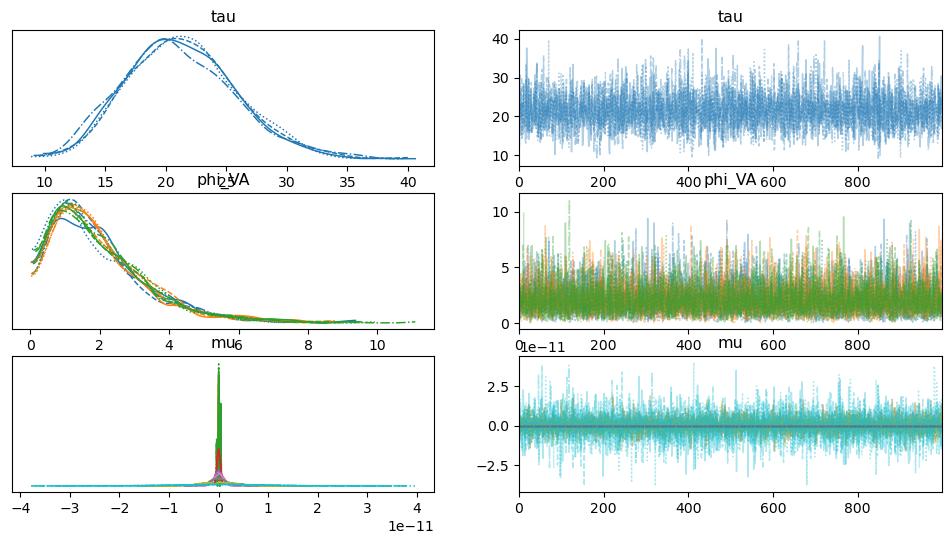

In [74]:
az.plot_trace(idata, var_names=["tau", "phi_VA", "mu"])